In [40]:
#from wsi_pipeline.experiments.shared.datasets import SharedDatasets, TMP_BASE_DIR
from pathlib import Path
from typing import List
import wget
import glob
import zipfile
import os
import shutil
from itertools import chain
import skimage.io
import skimage.transform
import skimage.feature
import skimage.measure
import skimage.segmentation
from pathlib import Path
import numpy as np
import pandas as pd
from importlib import reload  
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import cv2

In [2]:
import wsi_pipeline
import wsi_pipeline.os.file as File
from wsi_pipeline.core.pipeline import Pipeline
from wsi_pipeline.core.step import Step
from wsi_pipeline.libs.segmentation_mask_transform.segmentation_mask_transform import SegmentationMaskTransformer
from wsi_pipeline.libs.biomagdsb_cell_segmentation.style_transfer_segmentation import StyleTransferSegmentation
from wsi_pipeline.experiments.biomagdsb_cell_segmentation.adapters import DefaultStyleTransferSegmentationAdapter
from wsi_pipeline.image.image import NamedImage
from wsi_pipeline.util.functions import catch
from wsi_pipeline.loader.generators import FsImgReader
from wsi_pipeline.os.cwd import chcwd

In [3]:
reload(wsi_pipeline)
reload(wsi_pipeline.image.image)
reload(wsi_pipeline.experiments.biomagdsb_cell_segmentation.adapters)
reload(wsi_pipeline.libs.segmentation_mask_transform.segmentation_mask_transform)

<module 'wsi_pipeline.libs.segmentation_mask_transform.segmentation_mask_transform' from '/lustre/scratch2/ws/1/s7740678-wsi_pipeline_data/ml-based-image-classification-in-blast-pathology/wsi_pipeline/libs/segmentation_mask_transform/segmentation_mask_transform.py'>

In [4]:
SSD_DIR = Path.home() / "workspaces" / "ssd" / "s7740678-wsi_pipeline_tmp"
DATA_DIR = SSD_DIR / "data"
WSI_DIR = DATA_DIR / "wsi_originals"
TMP_DIR = SSD_DIR / "tmp"

In [5]:
def load_interim_results(root_dir):
    interim_results = {}
    for result_dir in glob.glob(str(root_dir / "*")):
        #print(result_dir)
        result_dir = Path(result_dir)
        for path in glob.glob(str(result_dir / "*")):
            id = Path(path).stem
            if id not in interim_results:
                interim_results[id] = {}
            #print(path)
            interim_results[id][result_dir.name] = NamedImage(Path(path).name, skimage.io.imread(path))
    return interim_results

In [6]:
def build_individual_cell_masks(wsi_mask):
    # Each cell has an individual gray value starting from 1. So nr of cells is highest gray value in the image 
    nr_of_cells = wsi_mask.np_array.max() 
    cell_masks = []
    black = np.zeros(wsi_mask.np_array.shape)

    for i in tqdm(range(1,nr_of_cells + 1), "Creating cell masks:"):
        if(np.any(wsi_mask.np_array == i)):
            single_cell_mask = np.copy(black)
            xy = np.where(wsi_mask.np_array == i)
            single_cell_mask[xy[0], xy[1]] = 1
            #resized_single_cell_mask = skimage.transform.resize(single_cell_mask, base_img_shape)
            #resized_single_cell_mask = skimage.util.img_as_ubyte(resized_single_cell_mask)
            #skimage.io.imsave(os.path.join(single_mask_dir, "{}_cell_{:04d}.png".format(mask_img_basename, i)), resized_single_cell_mask)
            cell_masks.append(NamedImage(f"{Path(wsi_mask.name).stem}_cell_{i}.png", single_cell_mask))
    return cell_masks

def wsi_mask_to_original_shape(mask, original_shape):
    mask[mask > 0] = 255
    mask = skimage.color.gray2rgb(mask)
    mask = skimage.transform.resize(mask, original_shape)
    mask = skimage.util.img_as_ubyte(mask)
    mask[mask > 0] = 255
    return mask

In [31]:
def create_overlayed_image(base_img, mask, alpha=0.5):
    overlay = skimage.util.img_as_float(mask)
    output = skimage.util.img_as_float(base_img.copy())
    cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)
    return output

In [42]:
def get_pixel_diameter_from_black_scale_bar(orig_img_gray):
    black_pixel_rows = np.where(orig_img_gray == 0)[0]
    (unique, counts) = np.unique(black_pixel_rows, return_counts=True)
    pixel_per_10_micrometers = max(counts) # / 3 # because img is still rgb, each pixel counts as 3
    pixel_diameter_in_micrometer = 10 / pixel_per_10_micrometers
    return pixel_diameter_in_micrometer

def extend_slice(orig_slice, pixel_diameter_in_micrometer, minimum, maximum, extend_by_micrometer = 4):
    pixel_extend = math.ceil(extend_by_micrometer / pixel_diameter_in_micrometer)
    start = max(minimum, orig_slice.start-pixel_extend)
    stop =  min(maximum, orig_slice.stop+pixel_extend)
    return slice(start, stop, orig_slice.step)

def extract_extended_slice_of_img(orig_img, slices, pixel_diameter_in_micrometer):
    extended_slices = []
    for i in range(len(slices)):
        extended_slices.append(extend_slice(slices[i], pixel_diameter_in_micrometer, 0, orig_img.shape[i]))

    return orig_img[tuple(extended_slices)]
    #x_slice = slices[1]

In [8]:
interim_results = load_interim_results(TMP_DIR / "interim_results")

In [9]:
OVERLAYS_DIR = TMP_DIR / "interim_results" / "overlays"
SINGLE_CELL_MASKS_DIR = TMP_DIR / "interim_results" / "single_cell_masks"
SINGLE_CELL_SLICES_DIR = TMP_DIR / "interim_results" / "single_cell_slices"

In [10]:
for DIR in [OVERLAYS_DIR, SINGLE_CELL_MASKS_DIR, SINGLE_CELL_SLICES_DIR]:
    if not DIR.is_dir():
        DIR.mkdir()

In [11]:
transformer = SegmentationMaskTransformer()

In [12]:
for id, results in interim_results.items():
    if "postprocessing" in results:
        print(results["postprocessing"])
        original = NamedImage(results["originals"].name, skimage.util.img_as_ubyte(results["originals"].np_array))
        original_mask = NamedImage(results["postprocessing"].name, skimage.util.img_as_ubyte(results["postprocessing"].np_array))
        cell_masks = build_individual_cell_masks(original_mask)
        for cell_mask in tqdm(cell_masks):
            cell_mask.np_array = skimage.transform.resize(cell_mask.np_array, original.np_array.shape)
            break
        original_mask.np_array = skimage.transform.resize(original_mask.np_array, original.np_array.shape)
        original_mask.np_array = skimage.util.img_as_ubyte(original_mask.np_array)
        overlay = create_overlayed_image(original.np_array , original_mask.np_array )
        break

/home/s7740678/user-kernel/ml-wsi-pipeline/lib/python3.7/site-packages/skimage/util/dtype.py:503: UserWarning: Downcasting uint16 to uint8 without scaling because max value 139 fits in uint8
  return convert(image, np.uint8, force_copy)
Creating cell masks::   9%|▊         | 12/139 [00:00<00:01, 113.67it/s]

NamedImage: circle_resize_dscale2_Pat22675-Slide46601-M5-50x.tiff


  0%|          | 0/139 [00:02<?, ?it/s]


In [38]:
pixel_diameter_in_micrometer = get_pixel_diameter_from_black_scale_bar(skimage.color.rgb2gray(original.np_array))
pixel_diameter_in_micrometer

0.06802721088435375

In [28]:
w = np.where(gray)
s = (slice(min(w[0]), max(w[0])), slice(min(w[1]), max(w[1])))

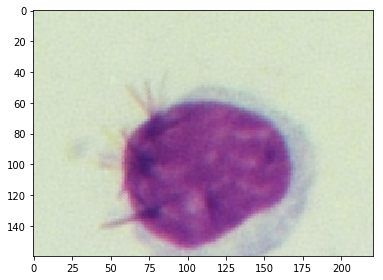

In [43]:
skimage.io.imshow(extract_extended_slice_of_img(original.np_array, s, pixel_diameter_in_micrometer))

In [40]:
original_mask.np_array[original_mask.np_array > 0]
        

array([24.75 , 24.75 , 24.75 , ...,  7.625,  7.625,  7.625])

In [23]:
gray = skimage.color.rgb2gray(cell_masks[0].np_array)
gray[gray>0]

array([0.0625, 0.1875, 0.25  , ..., 0.25  , 0.1875, 0.0625])

In [26]:
s

[slice(1819, 1910, None), slice(73, 176, None)]

In [39]:
np.any(gray,1).shape

(1920,)

In [41]:
original.np_array.shape

(1920, 2560, 3)

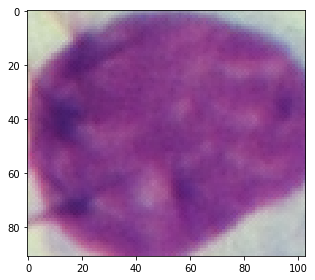

In [29]:
skimage.io.imshow(original.np_array[s])

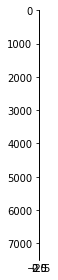

In [26]:
skimage.io.imshow(original.np_array[cell_masks[0].np_array[:,:,0] > 0])

/home/s7740678/user-kernel/ml-wsi-pipeline/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


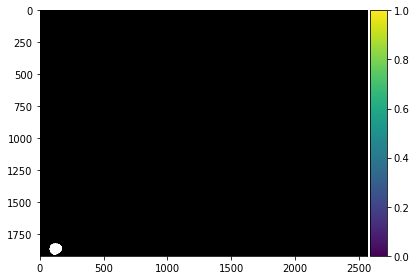

In [15]:
for cell_mask in cell_masks:
    skimage.io.imshow(cell_mask.np_array)
    break

/home/s7740678/user-kernel/ml-wsi-pipeline/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


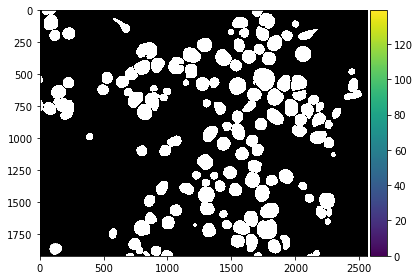

In [33]:
skimage.io.imshow(original_mask.np_array)

In [ ]:
labeled_mask = skimage.measure.label(original_mask, connectivity=1)

In [ ]:
regions = skimage.measure.regionprops(labeled_mask, intensity_image=skimage.color.rgb2gray(original))
for region in regions:
    print(region["area"])
#for prop in regions:
 #print(prop, region[prop])

In [ ]:
labeled_mask

In [ ]:
original[region.slice]

In [ ]:
skimage.io.imshow(original[regions[6].slice])

In [ ]:
region = regions[12]
sliced = original[region.slice]
white = np.ones(sliced.shape)
white[region.image] = sliced[region.image]
skimage.io.imshow(white)

In [ ]:
black[region.slice]

In [ ]:
bounds = skimage.segmentation.find_boundaries(labeled_mask, connectivity=1)
black = np.zeros(labeled_mask.shape)
black[region.slice][region.convex_image] = 0.5
black[bounds] = 1
skimage.io.imshow(black[region.slice])